# Points per Game
In this notebook, we only use each player's efficieny (per-game and per-touch stats) to predict their efficiency (Fantasy PPG) in the next season.

In [ ]:
# helper.py
from helper import *
gc.collect()

0

In [25]:
# load data
df = pd.read_csv('./data/clean/fantasy_data_pff.csv')

# ensure values are sorted properly
df = df.sort_values(by=['Key', 'Exp']).reset_index(drop=True)

# drop non-normalized columns
df = drop_total_volume_cols(df)

# drop some total volume columns and team-related cols
df_drops = ['Pass_dropbacks', 'Pass_passing_snaps', 'Pass_aimed_passes', 'Pass_def_gen_pressures', 'Pass_hit_as_threw', 'Pass_sacks', 'Rush_gap_attempts', 'Rush_zone_attempts', 'Rush_avoided_tackles', 'Rush_explosive', 
             'Rec_avoided_tackles', 'Rec_contested_receptions', 'Rec_contested_targets', 'Rec_inline_snaps', 'Rec_wide_snaps', 'Rec_slot_snaps', 'Rec_routes', 
             'Team_Tackling Grade', 'Team_Pass Rush Grade', 'Team_Coverage Grade', 'Team_Special Teams Grade', 'Team_Team Grade']
df = df.drop(columns=df_drops)

# rename target col
df = df.rename(columns={'PPGTarget_half-ppr': 'target'})

# check a row
df.sample()

,Player,Tm,Pos,Age,Year,games_played_pct,games_started_pct,Exp,Key,Pass_Cmp_per_game,Pass_Att_per_game,Pass_Yds_per_game,Pass_TD_per_game,Pass_Int_per_game,Rush_Att_per_game,Rush_Yds_per_game,Rush_TD_per_game,Rec_Tgt_per_game,Rec_Rec_per_game,Rec_Yds_per_game,Rec_TD_per_game,Fmb_per_game,FmbLost_per_game,Scrim_TD_per_game,Scrim_Yds_per_game,Touches_per_game,PPG_half-ppr,PPT_half-ppr,PPGOvrRank_half-ppr,PPGPosRank_half-ppr,PPTOvrRank_half-ppr,PPTPosRank_half-ppr,target,Pass_accuracy_percent,Pass_avg_depth_of_target,Pass_avg_time_to_throw,Pass_grades_pass,Pass_Dropback%,Pass_Aimed_passes%,Pass_Dropped_passes%,Pass_Batted_passes%,Pass_Thrown_away%,Pass_Pressure%,Pass_Scramble%,Pass_Sack%,Pass_Pressure_to_sack%,Pass_BTT%,Pass_TWP%,Pass_First_down%,Rush_elusive_rating,Rush_grades_run,Rush_longest,Rush_Team_Rush%,Rush_Avoided_tackles_per_attempt,Rush_10+_yard_run%,Rush_15+_yard_run%,Rush_15+_yard_run_yards%,Rush_First_down%,Rush_Gap%,Rush_Zone%,Rush_YCO_per_attempt,Rec_avg_depth_of_target,Rec_caught_percent,Rec_contested_catch_rate,Rec_drop_rate,Rec_grades_hands_drop,Rec_grades_pass_route,Rec_inline_rate,Rec_longest,Rec_pass_block_rate,Rec_route_rate,Rec_slot_rate,Rec_targeted_qb_rating,Rec_wide_rate,Rec_yards_after_catch_per_reception,Rec_yards_per_reception,Rec_yprr,Rec_Avoided_tackles_per_reception,Rec_First_down%,Rec_Int_per_target,Rec_YAC%,Rec_Contested_catch_rate,grades_offense,grades_hands_fumble,Team_Offense Grade,Team_Passing Grade,Team_Pass Blocking Grade,Team_Receiving Grade,Team_Rushing Grade,Team_Run Blocking Grade,Team_Defense Grade,Team_Run Defense Grade,Team_Win%,Team_PPG,Team_PPG_allowed,Team_Pass Defense Grade
595,Andrew Beck,DEN,TE,23,2019,1.0,0.375,0,BeckAn01,0.0625,0.0625,0.375,0.0,0.0,0.0625,0.1875,0.0,0.75,0.5625,5.625,0.0625,0.0,0.0,0.0625,5.8125,0.6875,1.2525,1.821818,414,78,214,69,0.0,100.0,-3.0,2.0,60.4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,61.4,3.0,0.008,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,3.2,90.0,0.0,10.0,56.7,62.5,27.4,29.0,16.0,78.3,4.7,137.5,17.0,7.3,10.0,1.08,0.0,0.666667,0.0,0.733333,0.0,58.8,71.8,69.9,58.8,74.3,71.1,78.1,61.1,83.6,91.2,0.4375,17.625,19.75,73.4


- We will be using normalized features (per-game stats and other percentages) along with __PPG half-ppr fantasy points__ as the target. 
- This will not punish players for missing games or getting injured (which is unfortunate but very common in the NFL).
- A [seperate model]() will be trained to determine injury probability based on past volume and games missed.

# Create Features

In [26]:
# aggregate data by player
features = create_features(df)

# show shape and nulls
show_shape_and_nulls(features)

Shape: (11503, 624)
Null values:


,Age,Exp,FmbLost_per_game,FmbLost_per_game_3y_mean,FmbLost_per_game_3y_std,FmbLost_per_game_career_mean,FmbLost_per_game_career_std,FmbLost_per_game_career_trend_slope,FmbLost_per_game_momentum,Fmb_per_game,Fmb_per_game_3y_mean,Fmb_per_game_3y_std,Fmb_per_game_career_mean,Fmb_per_game_career_std,Fmb_per_game_career_trend_slope,Fmb_per_game_momentum,Key,PPGOvrRank_half-ppr,PPGOvrRank_half-ppr_3y_mean,PPGOvrRank_half-ppr_3y_std,PPGOvrRank_half-ppr_career_mean,PPGOvrRank_half-ppr_career_std,PPGOvrRank_half-ppr_career_trend_slope,PPGOvrRank_half-ppr_momentum,PPGPosRank_half-ppr,PPGPosRank_half-ppr_3y_mean,PPGPosRank_half-ppr_3y_std,PPGPosRank_half-ppr_career_mean,PPGPosRank_half-ppr_career_std,PPGPosRank_half-ppr_career_trend_slope,PPGPosRank_half-ppr_momentum,PPG_half-ppr,PPG_half-ppr_3y_mean,PPG_half-ppr_3y_std,PPG_half-ppr_career_mean,PPG_half-ppr_career_std,PPG_half-ppr_career_trend_slope,PPG_half-ppr_momentum,PPTOvrRank_half-ppr,PPTOvrRank_half-ppr_3y_mean,PPTOvrRank_half-ppr_3y_std,PPTOvrRank_half-ppr_career_mean,PPTOvrRank_half-ppr_career_std,PPTOvrRank_half-ppr_career_trend_slope,PPTOvrRank_half-ppr_momentum,PPTPosRank_half-ppr,PPTPosRank_half-ppr_3y_mean,PPTPosRank_half-ppr_3y_std,PPTPosRank_half-ppr_career_mean,PPTPosRank_half-ppr_career_std,PPTPosRank_half-ppr_career_trend_slope,PPTPosRank_half-ppr_momentum,PPT_half-ppr,PPT_half-ppr_3y_mean,PPT_half-ppr_3y_std,PPT_half-ppr_career_mean,PPT_half-ppr_career_std,PPT_half-ppr_career_trend_slope,PPT_half-ppr_momentum,Pass_Aimed_passes%,Pass_Aimed_passes%_3y_mean,Pass_Aimed_passes%_3y_std,Pass_Aimed_passes%_career_mean,Pass_Aimed_passes%_career_std,Pass_Aimed_passes%_career_trend_slope,Pass_Aimed_passes%_momentum,Pass_Att_per_game,Pass_Att_per_game_3y_mean,Pass_Att_per_game_3y_std,Pass_Att_per_game_career_mean,Pass_Att_per_game_career_std,Pass_Att_per_game_career_trend_slope,Pass_Att_per_game_momentum,Pass_BTT%,Pass_BTT%_3y_mean,Pass_BTT%_3y_std,Pass_BTT%_career_mean,Pass_BTT%_career_std,Pass_BTT%_career_trend_slope,Pass_BTT%_momentum,Pass_Batted_passes%,Pass_Batted_passes%_3y_mean,Pass_Batted_passes%_3y_std,Pass_Batted_passes%_career_mean,Pass_Batted_passes%_career_std,Pass_Batted_passes%_career_trend_slope,Pass_Batted_passes%_momentum,Pass_Cmp_per_game,Pass_Cmp_per_game_3y_mean,Pass_Cmp_per_game_3y_std,Pass_Cmp_per_game_career_mean,Pass_Cmp_per_game_career_std,Pass_Cmp_per_game_career_trend_slope,Pass_Cmp_per_game_momentum,Pass_Dropback%,Pass_Dropback%_3y_mean,Pass_Dropback%_3y_std,Pass_Dropback%_career_mean,Pass_Dropback%_career_std,Pass_Dropback%_career_trend_slope,Pass_Dropback%_momentum,Pass_Dropped_passes%,Pass_Dropped_passes%_3y_mean,Pass_Dropped_passes%_3y_std,Pass_Dropped_passes%_career_mean,Pass_Dropped_passes%_career_std,Pass_Dropped_passes%_career_trend_slope,Pass_Dropped_passes%_momentum,Pass_First_down%,Pass_First_down%_3y_mean,Pass_First_down%_3y_std,Pass_First_down%_career_mean,Pass_First_down%_career_std,Pass_First_down%_career_trend_slope,Pass_First_down%_momentum,Pass_Int_per_game,Pass_Int_per_game_3y_mean,Pass_Int_per_game_3y_std,Pass_Int_per_game_career_mean,Pass_Int_per_game_career_std,Pass_Int_per_game_career_trend_slope,Pass_Int_per_game_momentum,Pass_Pressure%,Pass_Pressure%_3y_mean,Pass_Pressure%_3y_std,Pass_Pressure%_career_mean,Pass_Pressure%_career_std,Pass_Pressure%_career_trend_slope,Pass_Pressure%_momentum,Pass_Pressure_to_sack%,Pass_Pressure_to_sack%_3y_mean,Pass_Pressure_to_sack%_3y_std,Pass_Pressure_to_sack%_career_mean,Pass_Pressure_to_sack%_career_std,Pass_Pressure_to_sack%_career_trend_slope,Pass_Pressure_to_sack%_momentum,Pass_Sack%,Pass_Sack%_3y_mean,Pass_Sack%_3y_std,Pass_Sack%_career_mean,Pass_Sack%_career_std,Pass_Sack%_career_trend_slope,Pass_Sack%_momentum,Pass_Scramble%,Pass_Scramble%_3y_mean,Pass_Scramble%_3y_std,Pass_Scramble%_career_mean,Pass_Scramble%_career_std,Pass_Scramble%_career_trend_slope,Pass_Scramble%_momentum,Pass_TD_per_game,Pass_TD_per_game_3y_mean,Pass_TD_per_game_3y_std,Pass_TD_per_game_career_mean,Pass_TD_per_ga

- The only null values are held in the "Target" column (indicating players in their final season). We cannot use rows without a target to train, so they will be dropped here.

In [ ]:
# load qb grades
qb_grades = pd.read_csv('./data/clean/qb_grades.csv')

# create 'Tm_next' col
features = features.copy()
features['Tm_next'] = features.groupby('Key')['Tm'].shift(-1)

# get 2024 features
features_2024 = features[features['Year'] == 2024].copy()

# drop players with null target values (includes 2024)
features = features.dropna(subset='target')

# drop deuplicate cols
features_2024 = features_2024.drop(columns=['player', 'teamName'])

# merge qb_grades with both feature sets
features = features.merge(qb_grades, left_on=['Tm_next', 'Year'], right_on=['Tm', 'Year'], how='left').drop(columns=['Tm_y'])
features_2024 = features_2024.merge(qb_grades, left_on=['Tm_next', 'Year'], right_on=['Tm', 'Year'], how='left').drop(columns=['Tm_y'])

# fill 'multiple' and NaN 'next__year_Tm' rows with QB_grade of 70
features['QB_grade'] = features['QB_grade'].fillna(70)
features_2024['QB_grade'] = features_2024['QB_grade'].fillna(70)

In [30]:
# get 2024 features
# features_2024 = features[features['Year'] == 2024].copy()

# drop players with null target values
# features = features.dropna(subset='target')

# check
features_2024.isna().sum().sum()

970

In [31]:
show_shape_and_nulls(features_2024)

Shape: (629, 626)
Null values:


,Age,Exp,FmbLost_per_game,FmbLost_per_game_3y_mean,FmbLost_per_game_3y_std,FmbLost_per_game_career_mean,FmbLost_per_game_career_std,FmbLost_per_game_career_trend_slope,FmbLost_per_game_momentum,Fmb_per_game,Fmb_per_game_3y_mean,Fmb_per_game_3y_std,Fmb_per_game_career_mean,Fmb_per_game_career_std,Fmb_per_game_career_trend_slope,Fmb_per_game_momentum,Key,PPGOvrRank_half-ppr,PPGOvrRank_half-ppr_3y_mean,PPGOvrRank_half-ppr_3y_std,PPGOvrRank_half-ppr_career_mean,PPGOvrRank_half-ppr_career_std,PPGOvrRank_half-ppr_career_trend_slope,PPGOvrRank_half-ppr_momentum,PPGPosRank_half-ppr,PPGPosRank_half-ppr_3y_mean,PPGPosRank_half-ppr_3y_std,PPGPosRank_half-ppr_career_mean,PPGPosRank_half-ppr_career_std,PPGPosRank_half-ppr_career_trend_slope,PPGPosRank_half-ppr_momentum,PPG_half-ppr,PPG_half-ppr_3y_mean,PPG_half-ppr_3y_std,PPG_half-ppr_career_mean,PPG_half-ppr_career_std,PPG_half-ppr_career_trend_slope,PPG_half-ppr_momentum,PPTOvrRank_half-ppr,PPTOvrRank_half-ppr_3y_mean,PPTOvrRank_half-ppr_3y_std,PPTOvrRank_half-ppr_career_mean,PPTOvrRank_half-ppr_career_std,PPTOvrRank_half-ppr_career_trend_slope,PPTOvrRank_half-ppr_momentum,PPTPosRank_half-ppr,PPTPosRank_half-ppr_3y_mean,PPTPosRank_half-ppr_3y_std,PPTPosRank_half-ppr_career_mean,PPTPosRank_half-ppr_career_std,PPTPosRank_half-ppr_career_trend_slope,PPTPosRank_half-ppr_momentum,PPT_half-ppr,PPT_half-ppr_3y_mean,PPT_half-ppr_3y_std,PPT_half-ppr_career_mean,PPT_half-ppr_career_std,PPT_half-ppr_career_trend_slope,PPT_half-ppr_momentum,Pass_Aimed_passes%,Pass_Aimed_passes%_3y_mean,Pass_Aimed_passes%_3y_std,Pass_Aimed_passes%_career_mean,Pass_Aimed_passes%_career_std,Pass_Aimed_passes%_career_trend_slope,Pass_Aimed_passes%_momentum,Pass_Att_per_game,Pass_Att_per_game_3y_mean,Pass_Att_per_game_3y_std,Pass_Att_per_game_career_mean,Pass_Att_per_game_career_std,Pass_Att_per_game_career_trend_slope,Pass_Att_per_game_momentum,Pass_BTT%,Pass_BTT%_3y_mean,Pass_BTT%_3y_std,Pass_BTT%_career_mean,Pass_BTT%_career_std,Pass_BTT%_career_trend_slope,Pass_BTT%_momentum,Pass_Batted_passes%,Pass_Batted_passes%_3y_mean,Pass_Batted_passes%_3y_std,Pass_Batted_passes%_career_mean,Pass_Batted_passes%_career_std,Pass_Batted_passes%_career_trend_slope,Pass_Batted_passes%_momentum,Pass_Cmp_per_game,Pass_Cmp_per_game_3y_mean,Pass_Cmp_per_game_3y_std,Pass_Cmp_per_game_career_mean,Pass_Cmp_per_game_career_std,Pass_Cmp_per_game_career_trend_slope,Pass_Cmp_per_game_momentum,Pass_Dropback%,Pass_Dropback%_3y_mean,Pass_Dropback%_3y_std,Pass_Dropback%_career_mean,Pass_Dropback%_career_std,Pass_Dropback%_career_trend_slope,Pass_Dropback%_momentum,Pass_Dropped_passes%,Pass_Dropped_passes%_3y_mean,Pass_Dropped_passes%_3y_std,Pass_Dropped_passes%_career_mean,Pass_Dropped_passes%_career_std,Pass_Dropped_passes%_career_trend_slope,Pass_Dropped_passes%_momentum,Pass_First_down%,Pass_First_down%_3y_mean,Pass_First_down%_3y_std,Pass_First_down%_career_mean,Pass_First_down%_career_std,Pass_First_down%_career_trend_slope,Pass_First_down%_momentum,Pass_Int_per_game,Pass_Int_per_game_3y_mean,Pass_Int_per_game_3y_std,Pass_Int_per_game_career_mean,Pass_Int_per_game_career_std,Pass_Int_per_game_career_trend_slope,Pass_Int_per_game_momentum,Pass_Pressure%,Pass_Pressure%_3y_mean,Pass_Pressure%_3y_std,Pass_Pressure%_career_mean,Pass_Pressure%_career_std,Pass_Pressure%_career_trend_slope,Pass_Pressure%_momentum,Pass_Pressure_to_sack%,Pass_Pressure_to_sack%_3y_mean,Pass_Pressure_to_sack%_3y_std,Pass_Pressure_to_sack%_career_mean,Pass_Pressure_to_sack%_career_std,Pass_Pressure_to_sack%_career_trend_slope,Pass_Pressure_to_sack%_momentum,Pass_Sack%,Pass_Sack%_3y_mean,Pass_Sack%_3y_std,Pass_Sack%_career_mean,Pass_Sack%_career_std,Pass_Sack%_career_trend_slope,Pass_Sack%_momentum,Pass_Scramble%,Pass_Scramble%_3y_mean,Pass_Scramble%_3y_std,Pass_Scramble%_career_mean,Pass_Scramble%_career_std,Pass_Scramble%_career_trend_slope,Pass_Scramble%_momentum,Pass_TD_per_game,Pass_TD_per_game_3y_mean,Pass_TD_per_game_3y_std,Pass_TD_per_game_career_mean,Pass_TD_per_ga

# Positional Subsets

In [6]:
# get positional subsets
qb, rb, wr, te = get_pos_subsets(features)

# show shapes
qb.shape, rb.shape, wr.shape, te.shape

((1172, 449), (2431, 477), (3156, 477), (1776, 477))

# Baseline
- Baseline RMSE scores for the 3 positional subsets using an XGBoost with 1000 trees.

In [7]:
# iterate through subsets
for pos, data in zip(['QB', 'RB', 'WR', 'TE'], [qb, rb, wr, te]):
    # cross validate
    model = XGBRegressor(n_jobs=-1, random_state=SEED, n_estimators=1000)
    summary = cross_val(df=data, estimator=model)

    # show results
    print(f'--- {pos} ---')
    display(summary)

--- QB ---


,train_rmse,train_r2,val_rmse,val_r2
mean,0.000553,1.000000e+00,5.350102,0.440262
std,0.000018,3.822388e-10,0.185254,0.039647


--- RB ---


,train_rmse,train_r2,val_rmse,val_r2
mean,0.000693,1.000000e+00,3.633594,0.516862
std,0.000036,1.623367e-09,0.198487,0.071901


--- WR ---


,train_rmse,train_r2,val_rmse,val_r2
mean,0.000746,1.000000e+00,3.098813,0.550116
std,0.000033,2.364587e-09,0.084383,0.029495


--- TE ---


,train_rmse,train_r2,val_rmse,val_r2
mean,0.000712,1.000000e+00,2.280543,0.560781
std,0.000064,7.723289e-09,0.101956,0.053637


# Optimize XGBoost

In [8]:
# get X and y for the 3 subsets
X_qb, y_qb = get_X_y(qb)
X_rb, y_rb = get_X_y(rb)
X_wr, y_wr = get_X_y(wr)
X_te, y_te = get_X_y(te)

In [ ]:
# define the parameter search space
param_bounds = {'max_depth': (1, 10),
    'learning_rate': (0.0001, 0.01),
    'gamma': (0, 1),
    'subsample': (0, 1.0),
    'colsample_bytree': (0, 1.0),
    'min_child_weight': (0, 10)}

# bayesian optimize
optim_qb = run_bayes_opt(X_qb, y_qb, param_bounds, SEED)
optim_rb = run_bayes_opt(X_rb, y_rb, param_bounds, SEED)
optim_wr = run_bayes_opt(X_wr, y_wr, param_bounds, SEED)
optim_te = run_bayes_opt(X_te, y_te, param_bounds, SEED)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | -2.219    | 0.01037   | 0.5019    | 0.005008  | 2.204     | 1.421     | 0.2186    |
| 2         | -2.399    | 0.4185    | 0.2481    | 0.0009322 | 4.109     | 1.668     | 0.8786    |
| 3         | -2.122    | 0.951     | 0.03875   | 0.007021  | 6.155     | 8.98      | 0.6669    |
| 4         | -2.103    | 0.5478    | 0.7024    | 0.003926  | 7.25      | 8.249     | 0.4657    |
| 5         | -2.115    | 0.9405    | 0.8037    | 0.009835  | 2.527     | 5.211     | 0.9455    |
| 6         | -2.113    | 0.6659    | 1.0       | 0.00737   | 4.902     | 6.941     | 0.6344    |
| 7         | -2.13     | 1.0       | 1.0       | 0.01      | 1.894     | 8.021     | 0.6808    |
| 8         | -2.111    | 0.06649   | 0.4704    | 0.01      | 9.857     | 10.0      | 0.8697    |
| 9         | -2.188

In [16]:
optim_te.max

{'target': -2.1026100096752294,
 'params': {'colsample_bytree': 0.5478377830464816,
  'gamma': 0.7024274240680553,
  'learning_rate': 0.003926123979185188,
  'max_depth': 7.249948099880124,
  'min_child_weight': 8.248704645005482,
  'subsample': 0.46566847536726585}}

In [21]:
# get best params
best_params_qb = {'colsample_bytree': 0.9508414362373033,
   'gamma': 0.9829511813725073,
   'learning_rate': 0.00818088036451473,
   'max_depth': 3,
   'min_child_weight': 6,
   'subsample': 0.9342989244729221}
best_params_rb = {'colsample_bytree': 0.0868799866187755,
   'gamma': 0.33787049927378343,
   'learning_rate': 0.004427921171525542,
   'max_depth': 6,
   'min_child_weight': 3,
   'subsample': 0.930876891906753}
best_params_wr = {'colsample_bytree': 0.9062772769235077,
  'gamma': 0.7582779867966488,
  'learning_rate': 0.003534329342377645,
  'max_depth': 5,
  'min_child_weight': 6,
  'subsample': 0.496281717671187}
best_params_te = {'colsample_bytree': 0.5478377830464816,
  'gamma': 0.7024274240680553,
  'learning_rate': 0.003926123979185188,
  'max_depth': 7,
  'min_child_weight': 8,
  'subsample': 0.46566847536726585}

# define models
xgb_qb = get_xgb_model(best_params_qb)
xgb_rb = get_xgb_model(best_params_rb)
xgb_wr = get_xgb_model(best_params_wr)
xgb_te = get_xgb_model(best_params_te)

# 2024 Predictions
Here we will train on the 2006-2022 data and then use the 2023 data as the holdout test set to predict the 2024 grades.

In [22]:
# get 2024 predictions for each position
print('--- QB ---')
qb_preds = get_2024_preds(qb, xgb_qb)
print('--- RB ---')
rb_preds = get_2024_preds(rb, xgb_rb)
print('--- WR ---')
wr_preds = get_2024_preds(wr, xgb_wr)
print('--- TE ---')
te_preds = get_2024_preds(te, xgb_te)

--- QB ---
RMSE: 5.3895
R2: 0.4282

--- RB ---
RMSE: 3.2867
R2: 0.6487

--- WR ---
RMSE: 2.7717
R2: 0.6508

--- TE ---
RMSE: 1.8620
R2: 0.6694



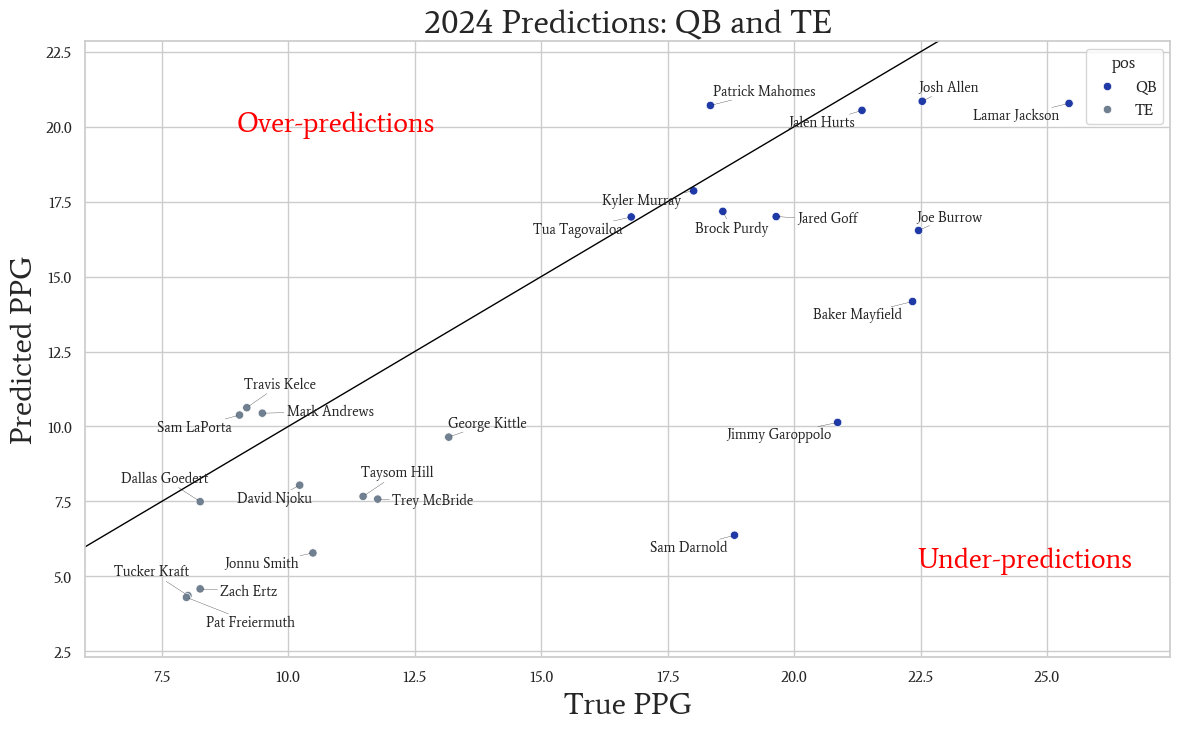

In [24]:
# get replacement-level players (top 12 QBs, 30 RBs, 42 WRs, and 12 TEs)
qb_repl = qb_preds.head(12)
rb_repl = rb_preds.head(30)
wr_repl = wr_preds.head(42)
te_repl = te_preds.head(12)

# plot QBs and TEs
plot_2024_preds(pd.concat([qb_repl, te_repl]), pos='QB and TE')

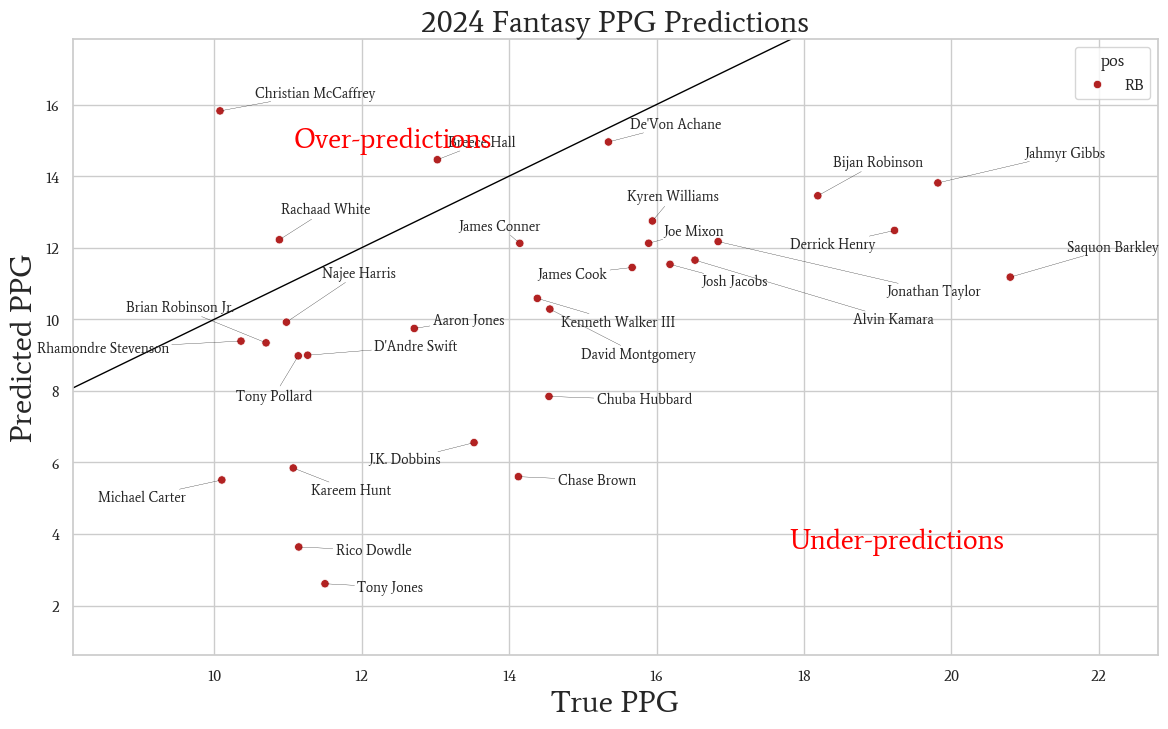

In [11]:
# plot RBs
plot_2024_preds(rb_repl)

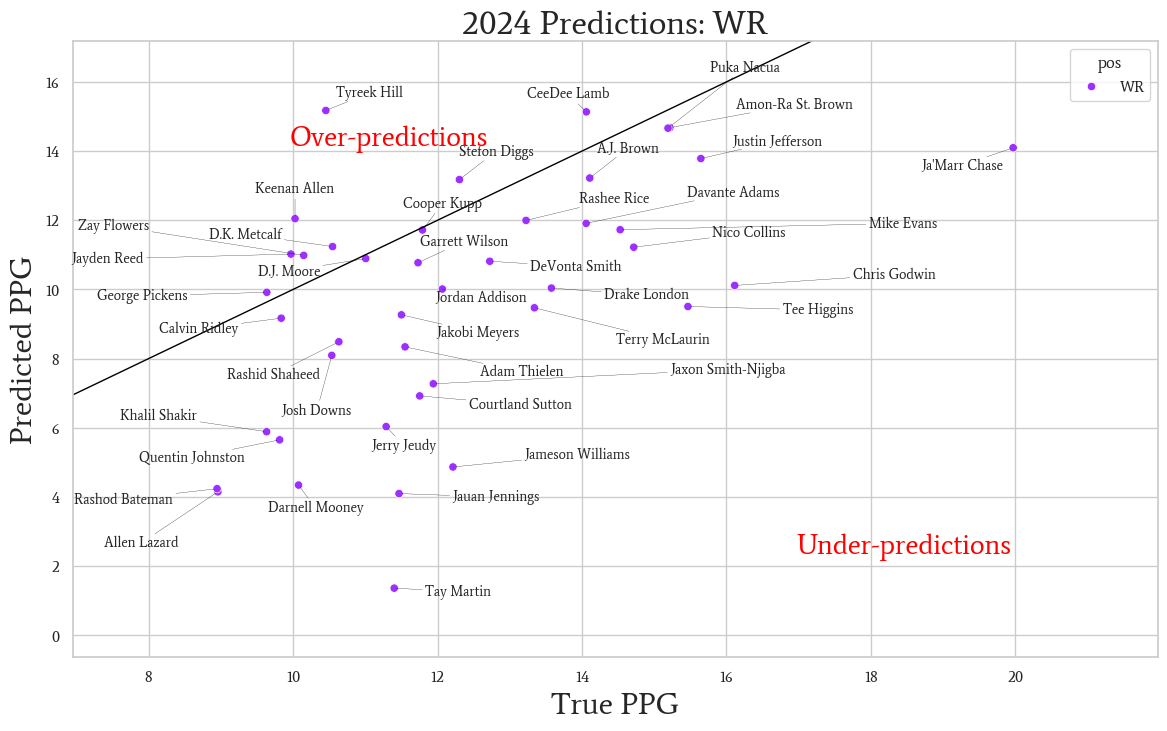

In [25]:
# plot WRs
plot_2024_preds(wr_repl, pos='WR')

# 2025 Predictions

In [26]:
# get positional subsets for 2024
qb_2024, rb_2024, wr_2024, te_2024 = get_pos_subsets(features_2024)

# fit models on all other data (1970-2023)
xgb_qb.fit(X_qb, y_qb)
xgb_rb.fit(X_rb, y_rb)
xgb_wr.fit(X_wr, y_wr)
xgb_te.fit(X_te, y_te)

# get 2025 predictions for each position
qb_preds_2025 = get_2025_preds(qb_2024, xgb_qb)
rb_preds_2025 = get_2025_preds(rb_2024, xgb_rb)
wr_preds_2025 = get_2025_preds(wr_2024, xgb_wr)
te_preds_2025 = get_2025_preds(te_2024, xgb_te)

# get replacement-level players (top 12 QBs, 30 RBs, 42 WRs, and 12 TEs)
qb_repl = qb_preds_2025.head(12)
rb_repl = rb_preds_2025.head(30)
wr_repl = wr_preds_2025.head(42)
te_repl = te_preds_2025.head(12)

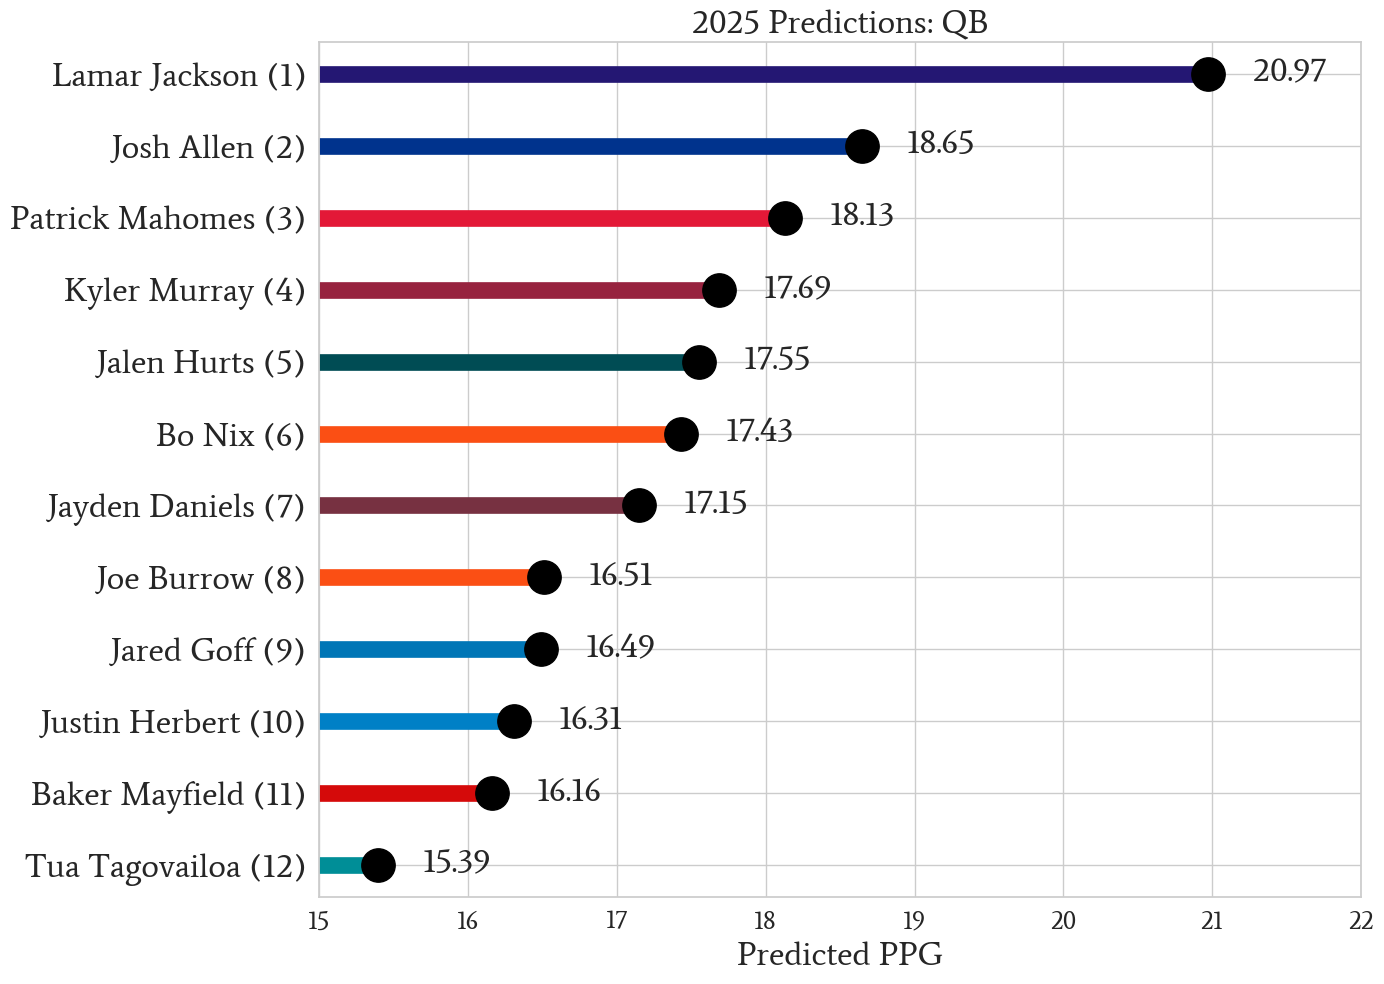

In [27]:
# plot QBs
plot_2025_preds(qb_repl, pos='QB', xlabel='Predicted PPG', xmin=15, xmax=22)

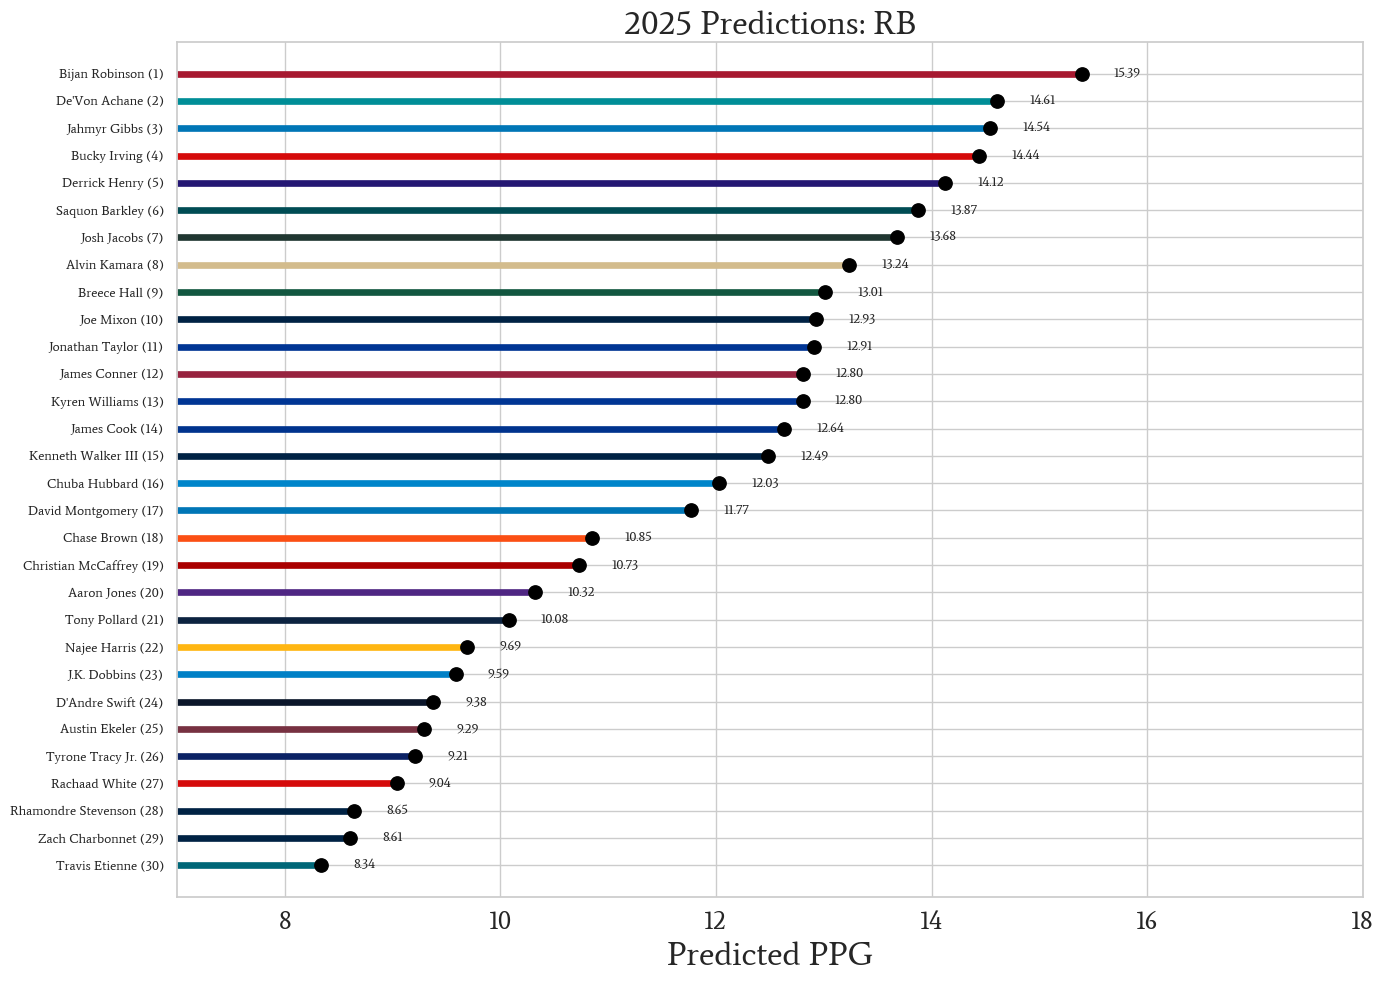

In [28]:
# plot RBs
plot_2025_preds(rb_repl, pos='RB', xlabel='Predicted PPG', xmin=7, xmax=18)

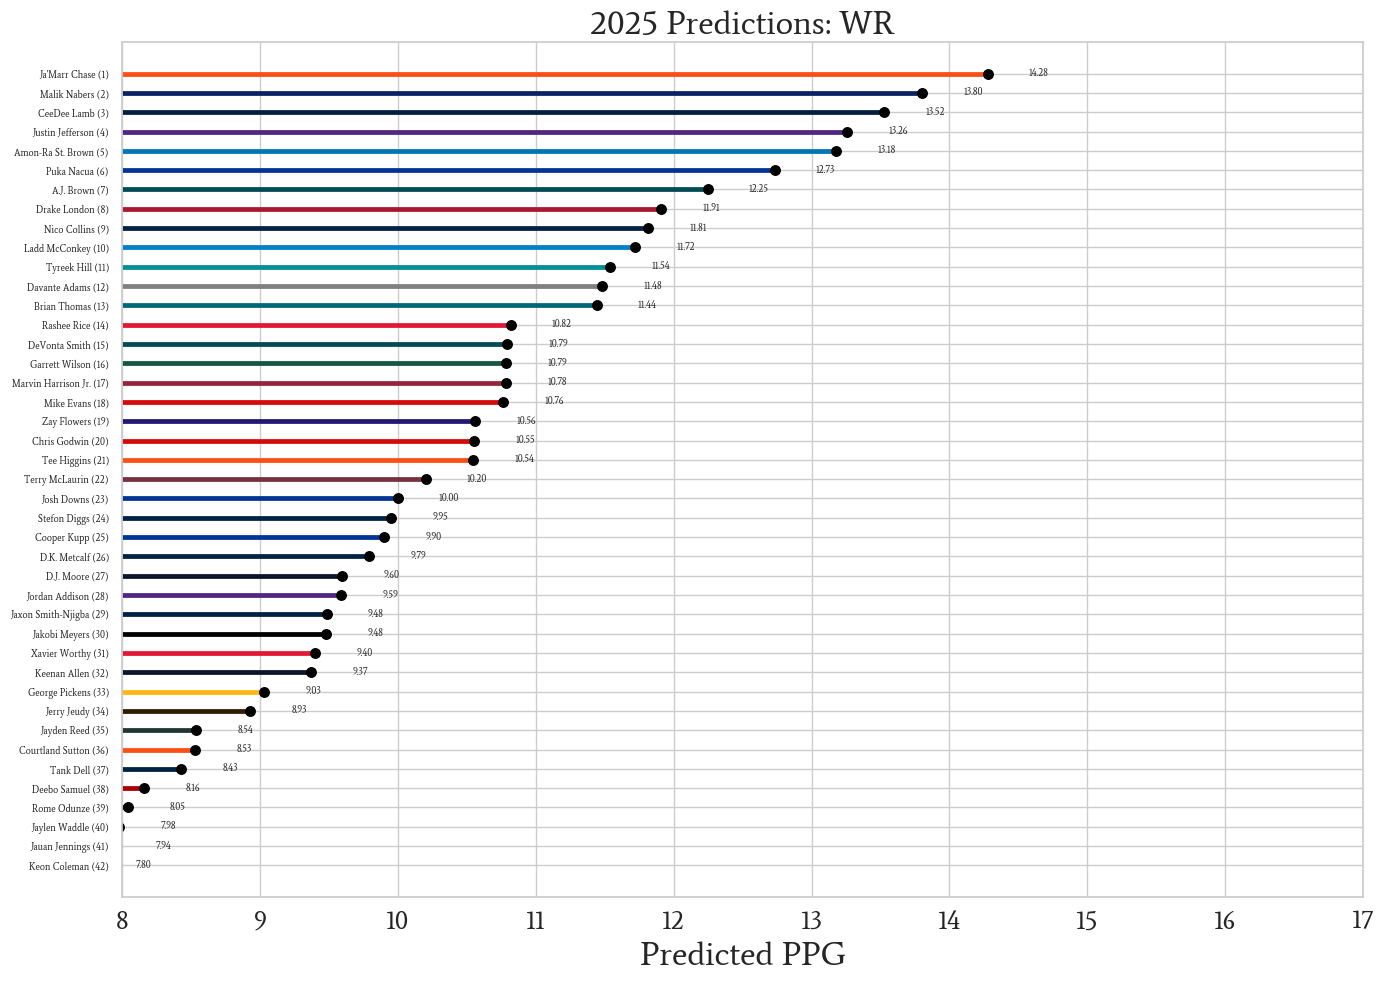

In [29]:
# plot WRs
plot_2025_preds(wr_repl, pos='WR', xlabel='Predicted PPG', xmin=8, xmax=17)

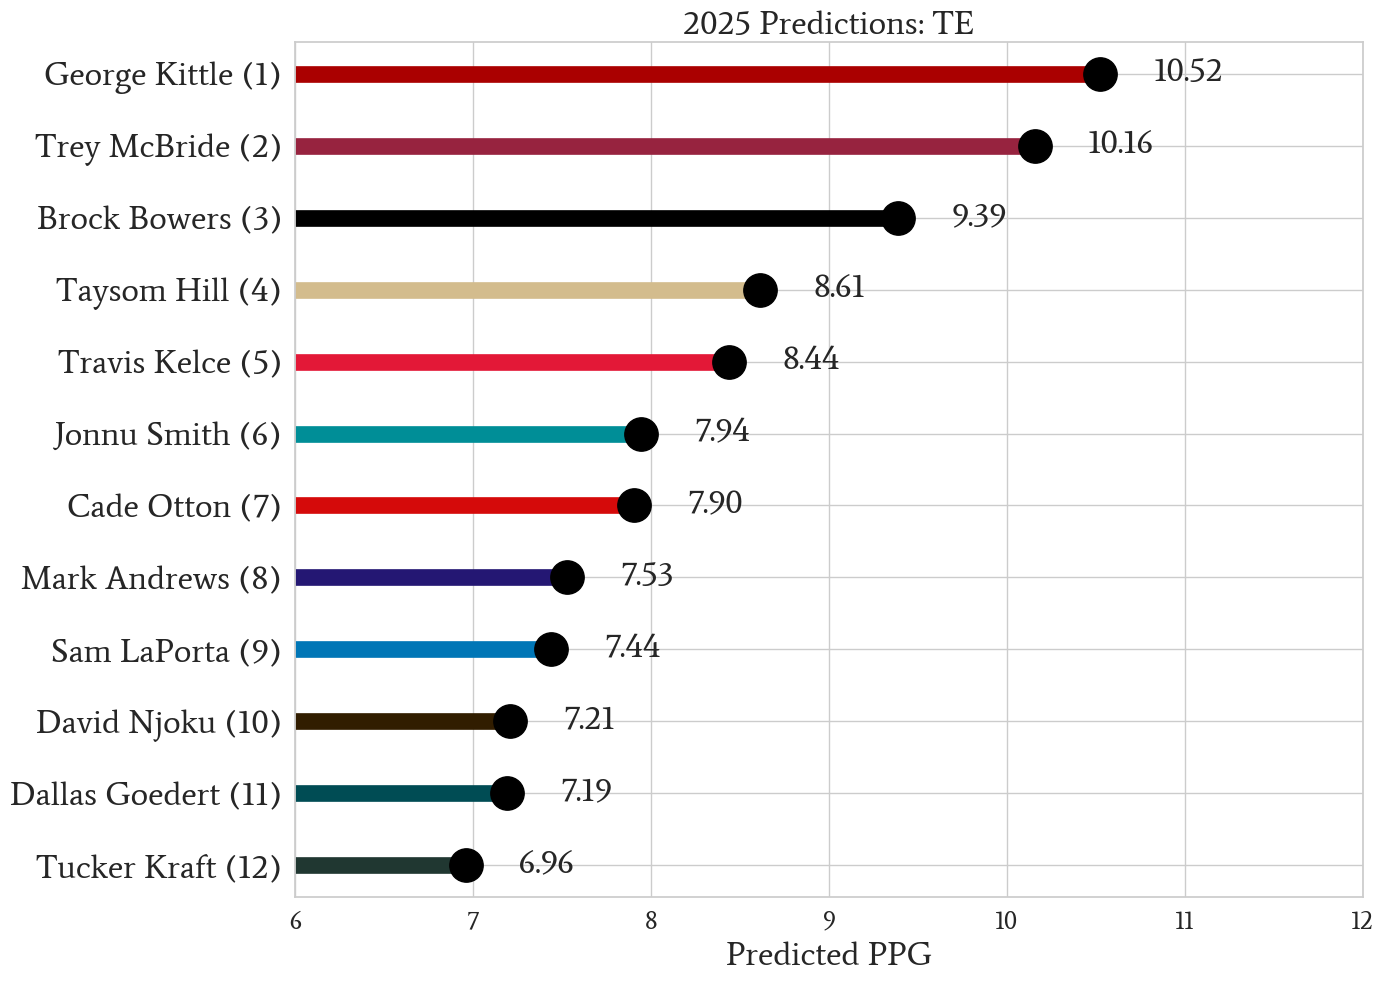

In [30]:
# plot TEs
plot_2025_preds(te_repl, pos='TE', xlabel='Predicted PPG', xmin=6, xmax=12)

In [9]:
# combine and save 2025 preds
preds_2025 = pd.concat([qb_preds_2025, rb_preds_2025, wr_preds_2025, te_preds_2025], axis=0).reset_index(drop=True)[['player', 'team', 'pos', 'y_pred']]

# get 2024 data
df_2024 = df.query('Year == 2024')

# add PPGPosRank_half-ppr and grades_offense columns to preds_2025
preds_2025 = preds_2025.merge(df_2024[['Player', 'Pos', 'PPGPosRank_half-ppr', 'grades_offense']], left_on=['player', 'pos'], right_on=['Player', 'Pos'], how='left')

# drop duplicate columns
preds_2025 = preds_2025.drop(columns=['Player', 'Pos'])

# rename cols
preds_2025 = preds_2025.rename(columns={'PPGPosRank_half-ppr': 'ppg_rank_2024', 'grades_offense': 'pff_grade_2024', 'y_pred': 'ppg_pred'})

# group by pos and add rank col
preds_2025['pred_rank_2025'] = preds_2025.groupby('pos')['ppg_pred'].rank(ascending=False, method='first')

# save
preds_2025.to_csv('./data/rankings/ppg_predictions_2025.csv', index=False)